## Perform all necessary imports

In [3]:
from hetmech.matrix import *
from hetmech.degree_weight import *

In [4]:
import json
import urllib.request
import numpy as np
import hetio.readwrite
import hetio.hetnet
import pandas as pd
import time
import random
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

## Load the graph

In [5]:
%%time
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetio.readwrite.read_graph(url)
metagraph = graph.metagraph

CPU times: user 1min 11s, sys: 1.53 s, total: 1min 12s
Wall time: 1min 16s


## Load metapaths

In [6]:
with urllib.request.urlopen('https://github.com/dhimmel/learn/raw/25093893ed53730ab5cfdac49561c4b6bd3376c5/all-features/data/metapaths.json') as data_file:
    metapaths = json.loads(data_file.read().decode())

metapaths.sort(key=lambda x: x['join_complexities'][0])

len(metapaths)

1206

In [7]:
# Extract the actual metapaths from the list of metapath dictionaries
abbrevs = [metapath['abbreviation'] for metapath in metapaths]

## Get a list of the metapaths that are incompatible with DWPC

In [7]:
incompatible_metapaths = []

for metapath in abbrevs:
    try:
        get_segments(graph.metagraph, metagraph.metapath_from_abbrev(metapath))
    except ValueError:
        mess = 'Incompatible'
        incompatible_metapaths.append(metapath)
'{} / {} were incompatible'.format(len(incompatible_metapaths), len(abbrevs))

'454 / 1206 were incompatible'

In [8]:
compatible_metapaths = [i for i in abbrevs if i not in incompatible_metapaths]
compatible_metapaths[0], len(compatible_metapaths), len(abbrevs)-len(compatible_metapaths)

('CiPCiCpD', 752, 454)

## Ensure that all DWPC matrices are indexed identically
This is necessary so that we can just use indices to sort dwpcs into vectors instead of searching by row and column.

In [8]:
rows, columns, mat = dwpc(graph, metagraph.metapath_from_abbrev('CiPCiCpD'), sparse_threshold=0.25)
exp_rows = rows
exp_cols = columns

In [25]:
%%time

for metapath in compatible_metapaths:
    rows, columns, mat = dwpc(graph, metagraph.metapath_from_abbrev(metapath), sparse_threshold=0.25)
    if (rows != exp_rows) or (columns != exp_cols):
        print(metapath)

CPU times: user 41min 42s, sys: 1min 12s, total: 42min 54s
Wall time: 42min 54s


The above cell shows that all the dwpc matrices will have the same rows and columns, meaning that the row/col combinations will be the same. So we will be able to sort the array into a vector the same way we did combinations of compound and disease names.

## Run through all DWPC metapaths -> table of compound/disease vs metapath_dwpc

In [24]:
%%time

compounds, diseases, mat = dwpc(graph, metagraph.metapath_from_abbrev(compatible_metapaths[0]))

times = []

# Generate a DataFrame with the proper compound/disease combinations
df = []
for compound in compounds:
    for disease in diseases:
        df.append([compound, disease])
df = pd.DataFrame(df, columns=('compounds', 'diseases'))
df.head()

# This will take many hours, probably ~6.5.
n = 0
for metapath in list(reversed(compatible_metapaths)):
    start = time.time()
    compounds, diseases, mat = dwpc(graph, metagraph.metapath_from_abbrev(metapath), sparse_threshold=0)
    df[metapath] = mat.flatten()
    tim = time.time() - start
    print("{:d} -- {:.2f} sec".format((n), (tim)))
    times.append(tim)
    n += 1

0 -- 17.08 sec
1 -- 17.77 sec
2 -- 16.77 sec
3 -- 16.82 sec
4 -- 16.88 sec
5 -- 17.39 sec
6 -- 16.95 sec
7 -- 16.82 sec
8 -- 16.73 sec
9 -- 15.63 sec
10 -- 18.69 sec
11 -- 19.13 sec
12 -- 16.38 sec
13 -- 15.57 sec
14 -- 15.44 sec
15 -- 15.76 sec
16 -- 16.59 sec
17 -- 13.93 sec
18 -- 13.89 sec
19 -- 13.97 sec
20 -- 13.79 sec
21 -- 13.91 sec
22 -- 13.73 sec
23 -- 15.38 sec
24 -- 15.71 sec
25 -- 15.26 sec
26 -- 15.56 sec
27 -- 15.52 sec
28 -- 16.73 sec
29 -- 15.72 sec
30 -- 15.24 sec
31 -- 15.28 sec
32 -- 16.02 sec
33 -- 15.20 sec
34 -- 15.49 sec
35 -- 15.18 sec
36 -- 15.45 sec
37 -- 15.61 sec
38 -- 15.25 sec
39 -- 15.63 sec
40 -- 16.31 sec
41 -- 15.75 sec
42 -- 15.33 sec
43 -- 2.17 sec
44 -- 2.11 sec
45 -- 14.01 sec
46 -- 2.16 sec
47 -- 2.10 sec
48 -- 13.86 sec
49 -- 13.74 sec
50 -- 13.45 sec
51 -- 1.93 sec
52 -- 15.31 sec
53 -- 15.77 sec
54 -- 15.42 sec
55 -- 16.02 sec
56 -- 17.09 sec
57 -- 15.65 sec
58 -- 15.63 sec
59 -- 15.64 sec
60 -- 13.60 sec
61 -- 1.92 sec
62 -- 2.17 sec
63 -- 2.0

489 -- 123.43 sec
490 -- 122.60 sec
491 -- 12.48 sec
492 -- 122.76 sec
493 -- 125.14 sec
494 -- 123.06 sec
495 -- 124.32 sec
496 -- 1.13 sec
497 -- 1.14 sec
498 -- 1.01 sec
499 -- 1.03 sec
500 -- 127.26 sec
501 -- 0.96 sec
502 -- 125.47 sec
503 -- 0.94 sec
504 -- 127.00 sec
505 -- 125.37 sec
506 -- 126.08 sec
507 -- 0.51 sec
508 -- 0.40 sec
509 -- 0.85 sec
510 -- 0.85 sec
511 -- 0.84 sec
512 -- 0.84 sec
513 -- 13.29 sec
514 -- 13.04 sec
515 -- 0.28 sec
516 -- 0.78 sec
517 -- 0.79 sec
518 -- 0.78 sec
519 -- 0.79 sec
520 -- 0.78 sec
521 -- 0.78 sec
522 -- 0.78 sec
523 -- 0.78 sec
524 -- 12.57 sec
525 -- 12.49 sec
526 -- 0.23 sec
527 -- 12.97 sec
528 -- 0.85 sec
529 -- 0.18 sec
530 -- 0.80 sec
531 -- 0.79 sec
532 -- 13.55 sec
533 -- 13.00 sec
534 -- 12.68 sec
535 -- 126.15 sec
536 -- 127.12 sec
537 -- 13.02 sec
538 -- 12.79 sec
539 -- 0.18 sec
540 -- 0.82 sec
541 -- 0.83 sec
542 -- 0.83 sec
543 -- 0.83 sec
544 -- 0.78 sec
545 -- 0.78 sec
546 -- 0.78 sec
547 -- 0.78 sec
548 -- 0.78 sec
549

In [25]:
df.head()

,compounds,diseases,CdGeAeGaD,CuGeAeGaD,CdGeAeGuD,CdGeAeGdD,CbGeAeGaD,CuGeAeGuD,CuGeAeGdD,CbGeAeGuD,...,CrCpD,CbGbCtD,CpDrD,CdGbCpD,CbGdCpD,CuGbCpD,CbGuCpD,CbGbCpD,CiPCiCtD,CiPCiCpD
0,DB00014,DOID:0050156,0.0,0.000017,0.0,0.0,0.000075,0.000094,0.000104,0.000421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DB00014,DOID:0050425,0.0,0.000015,0.0,0.0,0.000086,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DB00014,DOID:0050741,0.0,0.000021,0.0,0.0,0.000131,0.000090,0.000081,0.000476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DB00014,DOID:0050742,0.0,0.000012,0.0,0.0,0.000061,0.000102,0.000100,0.000369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DB00014,DOID:0060073,0.0,0.000014,0.0,0.0,0.000053,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df.to_csv(open('/home/zietz/Documents/hetmech/data/dwpc_metapaths.tsv', 'w'), sep='\t')

## runtime vs metapath

In [8]:
compounds, diseases, mat = dwpc(graph, metagraph.metapath_from_abbrev(compatible_metapaths[0]))

In [9]:
times = pd.read_csv('../times.csv')

del times['Unnamed: 0']

times['metapath'] = list(reversed(compatible_metapaths))
times['length'] = [sum([let.islower() for let in path]) for path in list(reversed(compatible_metapaths))]

cols = ['metapath', 'length', 'time']

times = times.reindex(columns=cols)
times.head()

,metapath,length,time
0,CdGeAeGaD,4,17.08
1,CuGeAeGaD,4,17.77
2,CdGeAeGuD,4,16.77
3,CdGeAeGdD,4,16.82
4,CbGeAeGaD,4,16.88


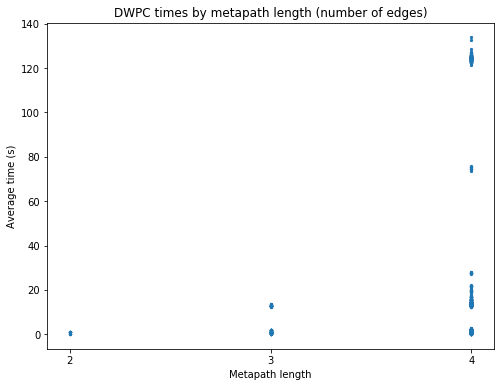

In [10]:
plt.figure(figsize=(8,6))
plt.title('DWPC times by metapath length (number of edges)')
plt.xlabel('Metapath length')
plt.ylabel('Average time (s)')
plt.xticks((2,3,4))

plt.scatter(times.length, times.time, s=5)

In [11]:
average_times = [np.average(times[times['length'] == i]['time']) for i in (2, 3, 4)]

<Container object of 3 artists>

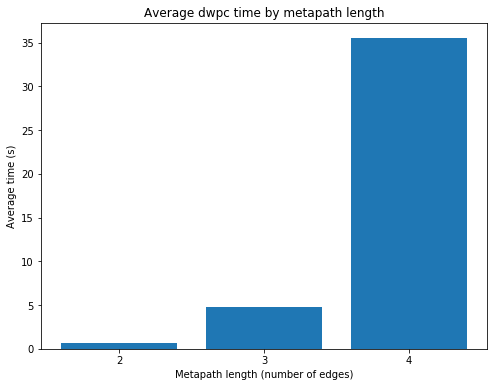

In [12]:
plt.figure(figsize=(8,6))
plt.title('Average dwpc time by metapath length')
plt.xlabel('Metapath length (number of edges)')
plt.ylabel('Average time (s)')
plt.xticks((2,3,4))
plt.bar([2,3,4], average_times)

In [13]:
length_times = []
for i in (2,3,4):
    length_times.append(list(times.loc[times['length'] == i]['time']))

length_times = pd.DataFrame(length_times).transpose()
length_times.columns = ['len2','len3','len4']
length_times.tail()

,len2,len3,len4
621,NaN,NaN,1.01
622,NaN,NaN,1.03
623,NaN,NaN,0.40
624,NaN,NaN,0.53
625,NaN,NaN,0.33


{'boxes': [<matplotlib.lines.Line2D at 0x7f7c30d408d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7c30d48eb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7c30cd5be0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7c30cd53c8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7c30d40a20>,
  <matplotlib.lines.Line2D at 0x7f7c30cfca58>]}

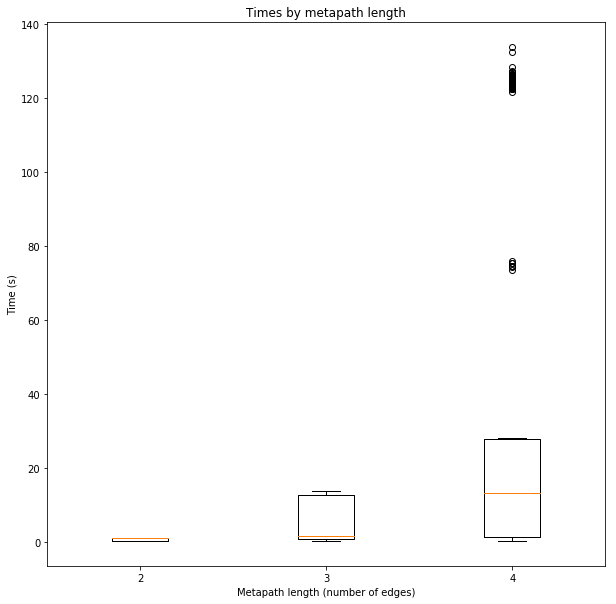

In [14]:
plt.figure(figsize=(10,10))
plt.title('Times by metapath length')
plt.xlabel('Metapath length (number of edges)')
plt.ylabel('Time (s)')
plt.boxplot([[i for i in list(length_times[col]) if not np.isnan(i)] for col in ['len2', 'len3', 'len4']], 
            labels=(list('234')))

## Get the metapaths with the longest runtimes

In [15]:
times_sorted = times.sort_values('time', ascending=False)

In [16]:
top15 = times_sorted.head(15)

top15

,metapath,length,time
408,CuGiGcGuD,4,133.82
409,CuGcGiGuD,4,132.53
265,CbGiG<rGaD,4,128.44
500,CdGcGcGuD,4,127.26
536,CbGcGcGdD,4,127.12
504,CbGcGcGaD,4,127.00
475,CbGcGiGuD,4,126.61
184,CuGiGiGaD,4,126.49
477,CbGiGcGdD,4,126.30
535,CbGcGcGuD,4,126.15


In [17]:
sorted_metapath_list = list(times_sorted['metapath'])

In [18]:
has_gg = []
for path in sorted_metapath_list:
    if re.findall('G.{1,2}G.{1,2}G', path):
        has_gg.append(2)
    elif re.findall('[^G].{1,2}G.{1,2}G.{1,2}[^G]', path):
        has_gg.append(1)
    else:
        has_gg.append(0)

In [19]:
times_sorted['has_gg'] = has_gg

In [20]:
times_sorted.head()

,metapath,length,time,has_gg
408,CuGiGcGuD,4,133.82,2
409,CuGcGiGuD,4,132.53,2
265,CbGiG<rGaD,4,128.44,2
500,CdGcGcGuD,4,127.26,2
536,CbGcGcGdD,4,127.12,2


In [21]:
np.average(list(times_sorted.time[times_sorted['has_gg'] == 2])) # Metapaths with G__G__G

124.52243055555556

In [22]:
np.average(list(times_sorted.time[times_sorted['has_gg'] == 1])) # Metapaths with G__G ONLY

13.177013888888887

In [23]:
np.average(list(times_sorted.time[times_sorted['has_gg'] == 0])) # Metapaths with no G__G

6.3510775862068964

## Find the relative sizes of the adjacency matrices

In [24]:
metaedges = []
for path in sorted_metapath_list:
    metaedges.extend([*re.findall('(?<![A-Z])[A-Z]{1,2}[^A-Z]{1,2}[A-Z]{1,2}', path, overlapped=True)])
metaedges = list(set(metaedges))
for i in metaedges:
    if i[::-1] in metaedges[metaedges.index(i)+1:]:
        metaedges.pop(metaedges.index(i))
print(metaedges)

['DuG', 'G<rG', 'CpD', 'GpMF', 'GpBP', 'AuG', 'DdG', 'SEcC', 'BPpG', 'CrC', 'CcSE', 'MFpG', 'AdG', 'GdA', 'DpS', 'SpD', 'DrD', 'PCiC', 'CbG', 'GuD', 'GcG', 'GuC', 'CtD', 'GuA', 'CiPC', 'PWpG', 'GdC', 'GpPW', 'Gr>G', 'AlD', 'GiG', 'GaD', 'AeG', 'CCpG']


In [25]:
%%time
metaedge_size = []
for edge in metaedges:
    rows, cols, mat = metaedge_to_adjacency_matrix(graph, edge, sparse_threshold=1)
    metaedge_size.append([edge, mat.shape, np.prod(mat.shape), mat.nnz / np.prod(mat.shape)])

metaedge_size = pd.DataFrame(metaedge_size, columns=["metaedge", "matrix shape", "n", "density"])

CPU times: user 19.5 s, sys: 8 ms, total: 19.5 s
Wall time: 19.7 s


In [27]:
metaedge_size.sort_values('n', ascending=False)

,metaedge,matrix shape,n,density
28,Gr>G,"(20945, 20945)",438693025,0.000606
20,GcG,"(20945, 20945)",438693025,0.000281
1,G<rG,"(20945, 20945)",438693025,0.000606
30,GiG,"(20945, 20945)",438693025,0.000671
4,GpBP,"(20945, 11381)",238375045,0.002347
8,BPpG,"(11381, 20945)",238375045,0.002347
11,MFpG,"(2884, 20945)",60405380,0.001609
3,GpMF,"(20945, 2884)",60405380,0.001609
25,PWpG,"(1822, 20945)",38161790,0.002211
27,GpPW,"(20945, 1822)",38161790,0.002211
